# 10. Time Series Forecasting in Tensorflow

Oh man this is hilarious, a 2 year old code-along where we will be writing a program to predict the price of Bitcoin 🤣

I predict that this forecasting neural network will perform quite horribly on any reasonable timeframe.

There are **two types** of Forecasting problems.
1. Classification (anomaly detection: Discrete)
2. Forecasting (price prediction: Continuous)

*Note:* this is a code-along taken from Daniel Bourke's [TensorFlow Deep Learning modules](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb). All code and text is manually written by me as a way of progressing my learning. 


## In this Notebook
1. Getting the timeseries data
 * Load in the timeseries data using pandas/Python CSV reader
2. Formatting the data to be used in a timeseries problem
 * Creating Training and Test sets
 * Visualizing the data
 * Transforming the data into a supervised learning problem
 * Univariate and Multivariate data prep
3. Evaluating a timeseries model
4. Creating a series of deep learning experiments
 * Dense networks
 * Sequence models (LSTM, GRUs, 1D CNN)
 * Ensemble models
 * Multivariate models
 * N-BEATS model replication using TensorFlow layers
5. Saving with checkpoints
6. Forecasting with a timeseries model
7. Varying prediction intervals
8. Covering *data uncertainty* vs *model uncertainty*
9. Demonstrating why predicing/forecasting in an open model is bullcrap
 

## Check for GPU
As always we want to be on GPU to run faster

In [3]:
# Check GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get data
In this notebook we are going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

Why this range? 01 October 2013 is when the data source (Coindesk) started collecting the price of Bitcoin and 18 May 2021 is when the code-along notebook was created.

We will pull this data from [Github](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv)

In [4]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-08-14 15:58:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.002s  

2022-08-14 15:58:52 (74.4 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing timeseries data with pandas

The datasource we are using is of CSV format, twhich is very common for timeseries data. We are going to read it using the `read_csv()` function. 

We will capture the dates in the proper date format by using `parse_dates` parameter

In [5]:
# Import with pandas
import pandas as pd

# Parse dates and create dataframe
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"],
                 index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
# Overview of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We can see that since we set the Date column as the index_col that it does not show on the list of columns. We can also see that we only have a small (2787) number of data points.

In [7]:
# Another way to see the number of samples
len(df)

2787

This is a recognized difficulty with timeseries problems. Even when we go back 8+ years as we do here, we only have <3k samples 

**Seasonality**
The frequency at which a time series value is collected is often referred to as seasonality. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. 

**Types of timeseries data**
* Trend: the data has a clear long-term pattern (e.g. increase or decrease)
* Seasonal: The data is impacted by seasonal factors (e.g. AC increase in summer, drink intake increase on weekends)
* Cyclic: the data shows rises and falls over unfixed, varying, time frames


We are going to start off by simplifying our dataset further and remove all but the date and closing price.

In [8]:
# Remove df columns
btc_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
btc_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


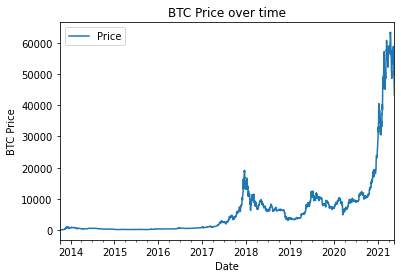

In [9]:
# Plotting the Price
import matplotlib.pyplot as plt
btc_prices.plot()
plt.ylabel("BTC Price")
plt.title("BTC Price over time")
plt.show()

## Importing timeseries data with Python's CSV module

We will recreate the plot we made before but with Python's built-in modules. We will use `datetime` to manage the dates column.

In [10]:
# Import with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0, 0.5, 'BTC Price')

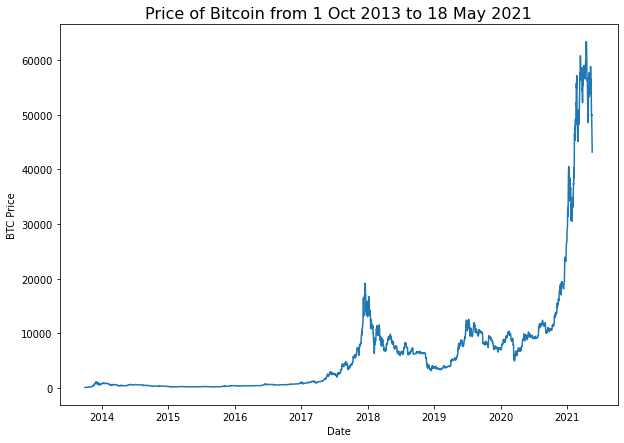

In [11]:
# Plot it again
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price")

Looks good! and since we used `datetime` we have a nice looking x-axis


## Format the data (Part 1) Timeseries' Train and Test datasets

Previously we used *Sci-Kit learn's* `train_test_split()`. As we will see, this doesn't work for time series data well. 

**Timeseries Data Types**
Timeseries data comes in either univariate or multivariate types 
* *Univariate* data deals only with one variable. i.e. price of a stock to predict a stock
* *Multivariate* data deals with multiple variables i.e. predicting electricity demand using the day of week, time of year and number of houses being served 

### Create train and test sets for timeseries data (incorrectly)

We still start with turning the DataFrame index and column into NumPy arrays.



In [12]:
# Get data array
timestamps = btc_prices.index.to_numpy()
prices = btc_prices["Price"].to_numpy()

timestamps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

Let's apply `train_test_split()` and see what happens. 

In [13]:
# incorrect way of splitting data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timestamps, #dates
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
                                                    

((2229,), (558,), (2229,), (558,))

It might be helpful to visualize how this split was made...

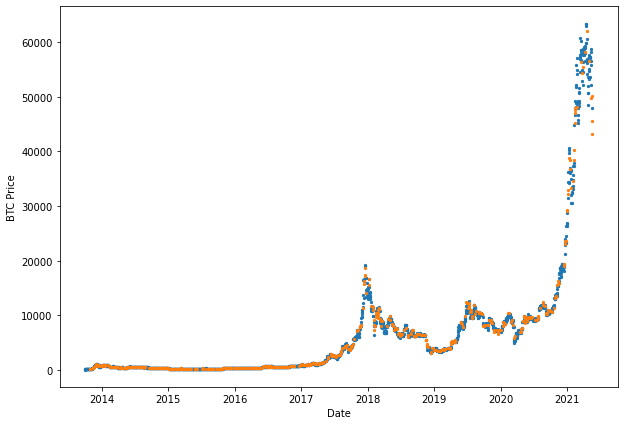

In [14]:
# Plot train and test splits
plt.figure(figsize=(10,7))
plt.scatter(x=X_train,
            y=y_train,
            s=5,
            label="train data")
plt.scatter(x=X_test,
            y=y_test,
            s=5,
            label="test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.show()

The way that this split was made does not make sense. We are trying to use past price to predict future price. This means that our test set would be... uh... the future price? 

This seems a bit tricker than what we have done in the past. 

### Create train adn test sets for timeseries data (correctly)

Since we cannot predict the future we need to split the data in a way that simulates this. 

The way that we will do this in thie module is we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

Perhaps it makes sense to take each point in time and then use the previous n-x datapoints to train on its future movement. But this is just me hypothesizing 


![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [15]:
# Correct approach to train and test set creation for timeseries 
split_size = int(0.8 * len(prices)) # 80-20 split

# Create Train data
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data 
X_test, y_test = timestamps[split_size:], prices[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

Okay, let's visualize this.

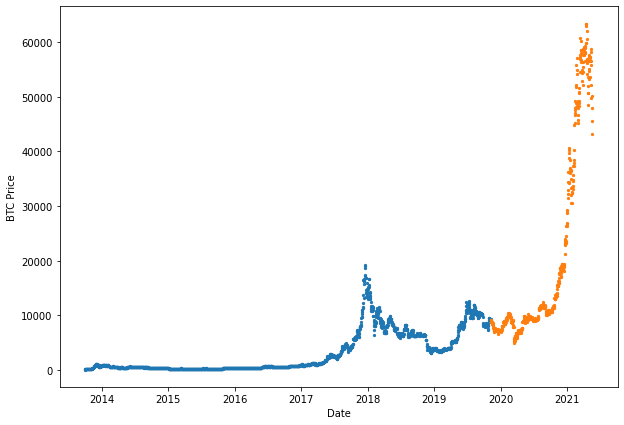

In [16]:
# Plot train and test splits
plt.figure(figsize=(10,7))
plt.scatter(x=X_train,
            y=y_train,
            s=5,
            label="train data")
plt.scatter(x=X_test,
            y=y_test,
            s=5,
            label="test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.show()

Hmmmmm this still doesn't seem like knowing anything about blue will help predict orange.

The amount of data you reserve for your test set not set in stone. You could have 80/20, 90/10, 95/5 splits or in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing.

### Creating a plotting fucntion

Because we will be plotting a lot, let's make a function

In [17]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

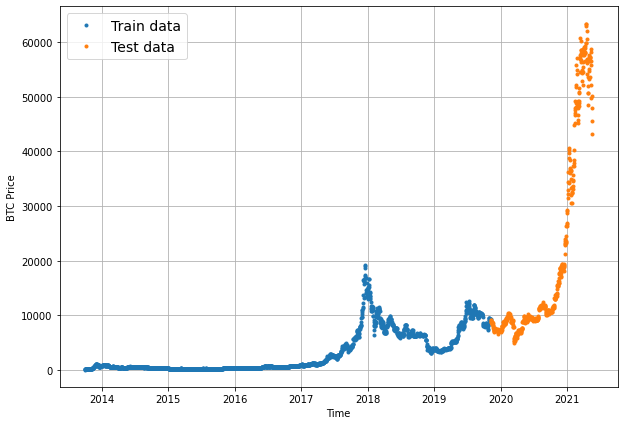

In [18]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

Now that we have preprocessed our data, let's get some experiments together for what models we want to create. 

For timeseries experiments there are two terms that are critical for defining the types of experiments we are going to run
 * **horizon** how far out (number of steps) that we are going to predict into the future
 * **window** how far back we look to predict the horizon

 The experiments that we are going to pursue in the module are as follows:
 
| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |


## Model_0: Baseline Model (Naive)

As is normal in machine learning we are going to start with a baseline model. For timeseries data is is common to use a naive model. 

A naive model does not need training as it only uses the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

**Sytem Types**
* **open system**: A system where inputs and outputs can freely flow, such as a market (stock or crypto). 
* **closed system**: A system where the inputs and outputs are contained within the system (like a poker game). 


Time series forecasting in **open systems** is generally quite poor.

### Creating the Model

In [19]:
# Create naive forecast
naive_forecast = y_test[:-1] #Naive forecast equals all values but the last one

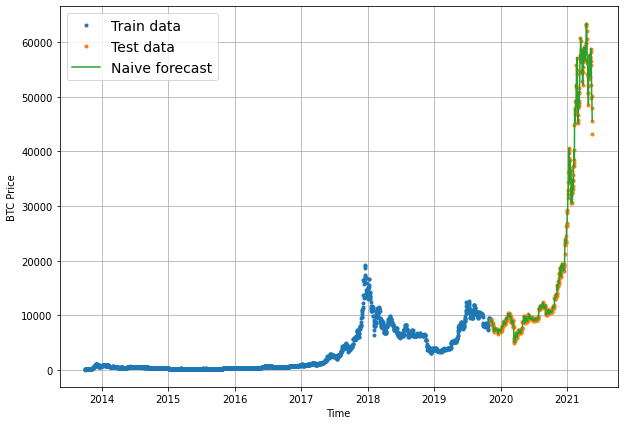

In [20]:
# Plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

Well... the naive forecast seems to plot well on top of the test data... Does that mean it's a good model? We shall see.. 

First, let's zoom in on the data a bit more.

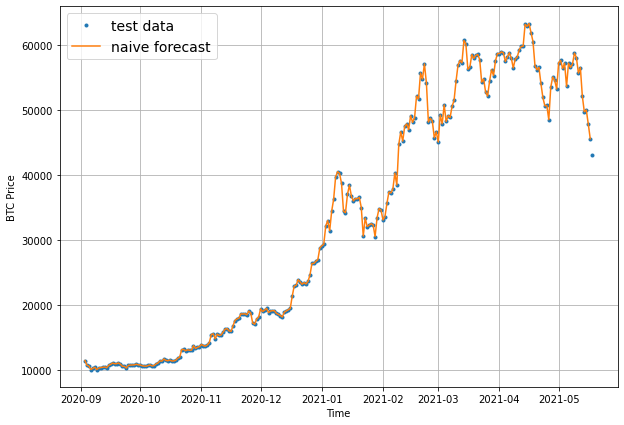

In [21]:
plt.figure(figsize=(10,7))
offset = 300 # exclude the first 300 datapoints
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="test data")
plot_time_series(timesteps=X_test[:-1], values=naive_forecast, start=offset, format="-", label="naive forecast")

Zooming in reveals what could have been exposed from looking at the naive forecast formula. The forecast comes slightly after the test data. This makes sense since we are setting the forecast of 1-timestep forward, equal to the current (or previous) timestamp.

Well, might as well see how this baseline model is doing and evaluate...

### Evaluating the model

Timeseries evaluation often consists of predicting a value. This is a **Regression** type of problem. Therefore we can evaluate it using **regression** evaluation techniques. This involves evaluating *how our prediction `y_pred` compares to the actual value `y_true`*.


### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


We will create our own MASE as tensorflow does not have it built in. We will use tensorflow to create this though.

In [22]:
# import TensorFlow
import tensorflow as tf

# MASE formula adopted from sktime's github.
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE with assumption of no seasonality
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # MAE assuming no seasonality
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # the seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

The naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's implement the other evaluation functions into a wrapper function

In [23]:
def evaluate_preds(y_true, y_pred):
  # Convert to same dtype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
# evaluate our naive forecast against these metrics
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [25]:
# average price in dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

So how are we doing? We see that the average price is 20,057, and that our forecast is off on average 567, or 2.5%. Is this a good forecast model..? Not really. Not because these metrics are bad, but because these metrics aren't telling a good story


Let's try building a better model.

## Other time series forecasting models

This code-along focuses on using TensorFlow, but there are many other resources that can do this.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data part 2: Windowing the dataset

Earlier we mentined the technique of windowing our data. Windowing allows us to turn a timeseries dataset into a **supervised learning problem**. It allows us to *use windows of the past to predict the future* (sliding window?).

Visual example:
```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

In [26]:
HORIZON = 1 # predict 1 step forward
WINDOW_SIZE = 7 # Use last 7 timestamps

In [27]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset
  """
  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test the function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


The above functions creates a single window. We need to create a function that creates windows for an entire timeseries dataset. 

First idea would be using Python 'for loops', but this is actually really slow. 

Instead we wil use [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

We will write a function where we:
1. Create a window step of a specific window size
2. Use Numpy indexing to create a 2D array of multiple window steps i.e.
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Use this 2D array to index on a target series
4. Use the `get_labelled_windows()` function to turn the window steps into windows with a specified horizon.

This function has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [29]:
# Function to view Numpy Arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 2D array into a 2D array of sequential windows of window_size
  """
  # 1. Create a window of a specific window_size. We add horizon on the end for later labeling.
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  print(f"Window step:\n {window_step}")

  #2. Create 2D array of multiple window steps (minus 1 to accoutn for 0 indexing).
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on teh target array (timeseries) with 2D array of miltiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [30]:
# test the above function
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows, full_labels

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 (array([[0, 1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8],
       [2, 3, 4, 5, 6, 7, 8, 9]]), array([[2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784],
       [2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785],
       [2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786]]), (2780, 8))


(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


TensorFlow Keras has a preprocessing function built-in that achieves a similar result.
`tf.keras.preprocessing.timeseries_dataset_from_array()`. It looks like we will use this function later


## Turning windows into training and test sets

Let's turn our windows into training and testing splits now

In [32]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  
  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [34]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Our model's performance will fluctuate from experiment to experiment, we want to compare our experiments 'apples to apples'. Therefore we will **compare each model's best performance against each other model's best performance**

e.g. this means that if `model_1` performs really well on epoch 20, but then falls off in regards to performance by epoch 40, we only capture the best epoch result. 

As with previous modules we will do this through implementing a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

This callback will monitor our model's performance during training and save the best model only.

Because we are running multiple experiments we will write a wrapper function for calling the `ModelCheckpoint` callback that saves a model to a specific name.

In [35]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model_1: Dense model (window=7, horizon=1)

The amount of preprocessing that we did is not abnormal. Oftentimes most of the work goes into the preprocessing stage. 

We are going to start simple.

Model_1 Components:
 * Single dense layer with 128 hidden units and ReLU activation
 * An output layer with linear activation
 * Adam optimizer and MAE loss function
 * batch size of 128
 * 100 epochs

 Note: a batch size of 32 works pretty well too. We are using sich a large number of expochs as compared to before because of how quickly our model trains. 



In [36]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for repeatability
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 1s 46ms/step - loss: 780.3469 - mae: 780.3469 - val_loss: 2279.5828 - val_mae: 2279.5828
Epoch 2/100
18/18 [==============================] - 0s 28ms/step - loss: 247.6765 - mae: 247.6765 - val_loss: 1005.9864 - val_mae: 1005.9864
Epoch 3/100
18/18 [==============================] - 0s 29ms/step - loss: 188.4107 - mae: 188.4107 - val_loss: 923.2859 - val_mae: 923.2859
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 169.4334 - mae: 169.4334 - val_loss: 900.5932 - val_mae: 900.5932
Epoch 5/100
18/18 [==============================] - 0s 29ms/step - loss: 165.0900 - mae: 165.0900 - val_loss: 895.2405 - val_mae: 895.2405
Epoch 6/100
18/18 [==============================] - 1s 29ms/step - loss: 158.5206 - mae: 158.5206 - val_loss: 855.1868 - val_mae: 855.1868
Epoch 7/100
18/18 [==============================] - 1s 39ms/step - loss: 151.3568 - mae: 151.3568 - val_loss: 840.9290 - val_mae: 840.9290
Epoch 8/100
18/1

In [37]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 662.5322 - mae: 662.5322


[662.5322265625, 662.5322265625]

Because we call `evaluate` on the model, as trained for 100 epochs, we see that its performance is the same as what was returned on epoch 100.

To get our best performance we will load the `ModelCheckpoint` callback

In [38]:
# Load the best performing epoch of model_1
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 568.5499 - mae: 568.5499


[568.5498657226562, 568.5498657226562]

## Making forecasts with a model (on the test dataset)

How can we use our model to make predictions?

Since we are running multiple models let's make a function that:
1. Takes in a trained model
2. Takes in some input data (e.g. the data used to train the model)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [39]:
def make_preds(model, input_data):
  """
  Use model to make predictions about input_data

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind that trained the model being used)

  Returns model predictions on input data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # returns a 1D array of predictions

In [40]:
# Make predictions using model_1 on test dataset 
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8874.493, 8789.944, 9040.986, 8804.829, 8741.21 , 8749.835,
       8705.865, 8513.171, 8478.415, 8536.302], dtype=float32)>

What we need to keep in mind is that our model *isn't truly making predictions*. To truly make predictions we would need to apply it in real time to the future. Our test dataset is only a *pseudofuture*

In [41]:
# Evaludate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

In [42]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

Looks like we did not beat the baseline model!

(note baseline model does so well because of temporal correlation)


Let's plot the `model_1_preds` against the test data using `plot_time_series()`

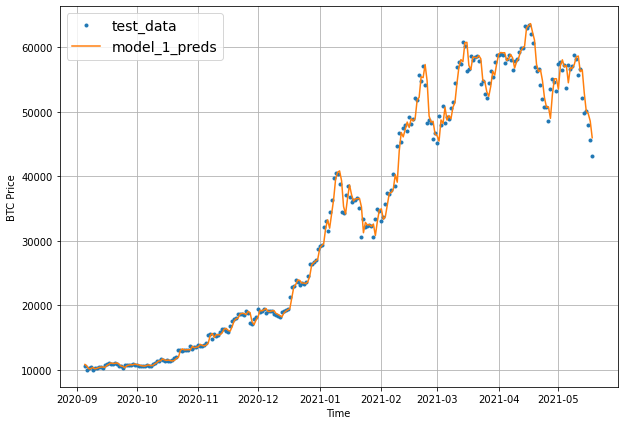

In [43]:
# Plot model_1 against test data
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window=30, horizon=1)

We will try to beat our baseline model by looking further in the past! What will happen??



In [44]:
HORIZON = 1
WINDOW_SIZE = 30

In [45]:
# Create updated window and label sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
Window indexes:
 (array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]), array([[2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
        2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
        2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784],
       [2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
        2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
        2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785],
       [2756, 2757, 27

(2757, 2757)

In [46]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows)


(2205, 552)

In [ ]:
tf.random.set_seed(42)

# Create the model (same model as model_1, input will be different only)
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model_2_ preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 658.0289


658.0288696289062

In [ ]:
# Load the best performing model_2
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 16ms/step - loss: 608.8480


608.8480224609375

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2, input_data=test_windows)

In [ ]:
# Evaluate results for predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.84814,
 'mape': 2.7680664,
 'mase': 1.0642724,
 'mse': 1284314.4,
 'rmse': 1133.276}

More history to learn from =/= better results! `model_2` is worse than both `model_0` and `model_1`.

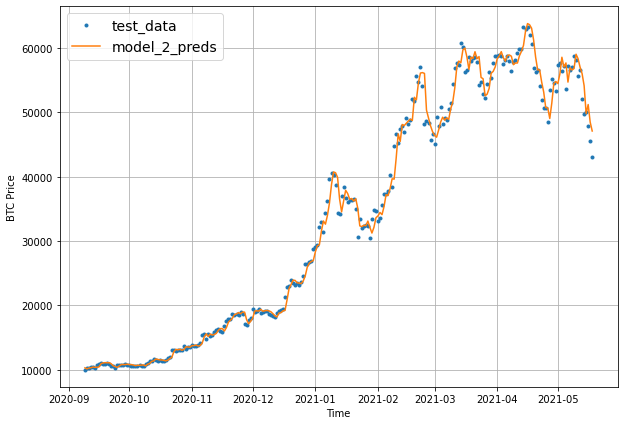

In [ ]:
# Visualize model_2 predictions
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model_3: Dense (window=30, horizon=7)

We've compared two different window sizes, but what about trying to predict further out? How does this impact performance?

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]
Window indexes:
 (array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]]), array([[2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758,
        2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769,
        2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780,
        2781, 2782, 2783, 2784],
       [2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
 

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)


Same model again as `model_1` and `model_2`

In [ ]:
tf.random.set_seed(42)

# Create
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

#fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Let's do it again!
* Evaluate
* Predict
* Show results

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1322.7781


1322.778076171875

In [ ]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1228.1417


1228.1417236328125

This makes sense that the error is larger because we are trying to predict more steps in the future. 

In [ ]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:2]

<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[9233.328, 9332.702, 9363.651, 9442.775, 9401.978, 9414.001,
        9280.01 ],
       [8911.084, 9065.984, 9113.08 , 9026.601, 8990.093, 9000.148,
        9053.433]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  559.42004 ,   276.0053  ,   298.20258 ,   408.06152 ,
          431.32047 ,   526.28064 ,   542.41644 ,   459.79108 ,
          490.63736 ,   631.6582  ,   802.51654 ,   731.79333 ,
          684.06476 ,   789.71857 ,   563.4593  ,   271.9013  ,
          231.86858 ,   258.64767 ,   277.65277 ,   291.5478  ,
          105.425575,   132.63156 ,   205.97643 ,   262.20816 ,
          169.8651  ,   165.05127 ,   110.21959 ,    83.64655 ,
          115.86182 ,   152.87025 ,   279.98862 ,   380.96127 ,
          280.21414 ,   271.9101  ,   264.43088 ,   261.91315 ,
          330.29108 ,   242.21861 ,   253.72746 ,   245.38596 ,
          412.562   ,   128.63539 ,    88.56452 ,    92.15639 ,
          100.39704 ,   102.41455 ,    74.52804 ,    94.00349 ,
           84.86837 ,    76.64781 ,   108.49679 ,   144.869   ,
          187.69133 ,   162.5261  ,   265.83133 ,   391.21323 ,
          552.2943  ,   541.77313 ,   522.20886 ,   523.98157 ,
          430.13052 ,   276.80893

## Evaluation functions for larger horizons

Our output for `model_3_results` is multidimensional because the predictions are being evaluated across the `HORIZON` timesteps (in this case 7 predictions at a time).make_preds

We can adjust this by changing our `evaluate_preds()` function to work with multiple shapes of data.

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Convert to float32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Allow one output for multiple dimension horizons
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

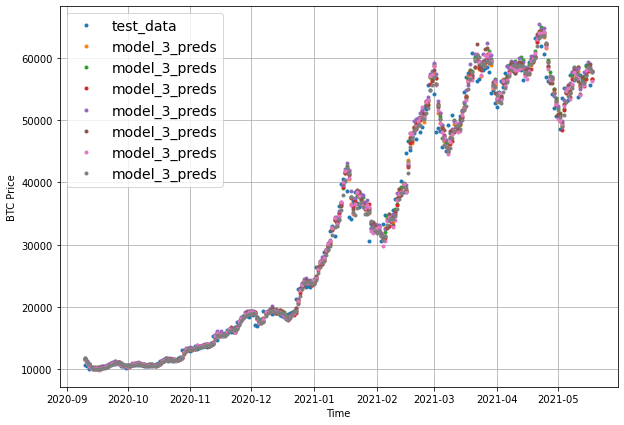

In [ ]:
offset=300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

The plot looks odd because we are plotting every prediction. It's hard to see what is going on when we look at timestep=7 only. Let's aggregate. This loses some information but will make it easier to see one datapoint per prediction.

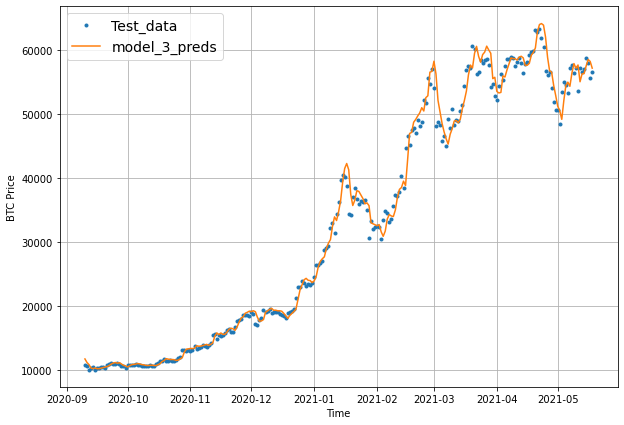

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Let's check in with our performance 

Which model is performing the best?

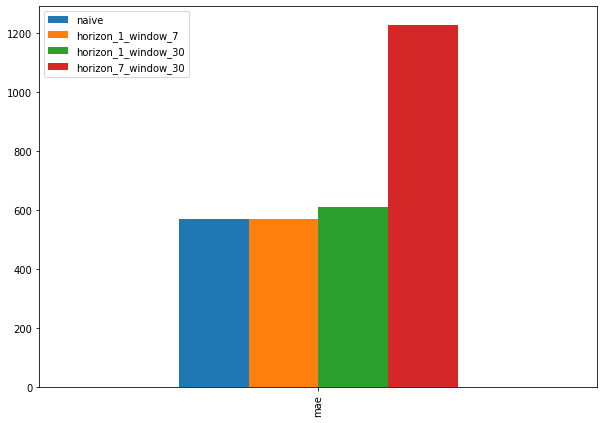

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]},
              index=["mae"]).plot(figsize=(10,7), kind="bar")

We see that the naive is performing best, but we see that horizon_1_window_7 is very close behind. Therefore moving forward we will use this model for our next set of experiments. 

## Model_4: Conv1D

Conv1D can be used for sequence problems successfully, and we can look at our problem here as a many to one sequence problem (7 days to next day output).

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 (array([[0, 1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8],
       [2, 3, 4, 5, 6, 7, 8, 9]]), array([[2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784],
       [2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785],
       [2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786]]), (2780, 8))


(2780, 2780)

In [ ]:
# Create train_test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Because we are using conv1D layers we need to adjust our input data shape. A conv1D layer needs the size `(batch_size, timesteps, input_dim)`.

* batch_size =32
* timesteps = WINDOW_SIZE
* input_dim = HORIZON

We are going to adjust the shape of our `train_windows` using a Lambda layer (tf.keras.layers.Lambda). This layer wraps a function into a layer to be used within a model.

In [ ]:
# Check original train_windows shape
train_windows[0].shape

(7,)

In [ ]:
# Reshape our input layer to work with a 1-dimensional convolutional layer. 
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # Adds an additional dimension for the timestamps

# View the output 
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size = 5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1d")

# Compile the model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary() # specifically what does the lambda layer look like?

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load best performing model_4 weights
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1d")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.0326


569.0325927734375

In [ ]:
# Predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8847.293, 8757.503, 8997.469, 8762.801, 8707.722, 8713.594,
       8664.935, 8496.83 , 8439.473, 8499.395], dtype=float32)>

In [ ]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.03265,
 'mape': 2.5515256,
 'mase': 0.9996328,
 'mse': 1169841.0,
 'rmse': 1081.5919}

## model_5: LSTM

We can also build a timeseries neural network using a recurrent (in this case a Long Short-term Memory (LSTM)) model.

We will reuse the data from the Conv1D model, except this time we will create a LSTM-cell powered recurrent neural network (RNN) 

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.

In [ ]:
tf.random.set_seed(42)

# Using the functional API to create the model
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Load in best version of model 5 and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 591.6655


591.6654663085938

In [ ]:
# Make predictions for LSTM 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8970.957, 8815.352, 9026.793, 8831.478, 8736.686, 8804.464,
       8733.207, 8540.421, 8518.281, 8544.508], dtype=float32)>

In [ ]:
# Evaluate model_5
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 591.6655,
 'mape': 2.66558,
 'mase': 1.0393925,
 'mse': 1250831.5,
 'rmse': 1118.4058}

We can see that the LSTM model performs wose than our benchmark naive model. 

## Make a multi-variate timeseries model

The first 5 models we created lost against, or barely beat the naive model. 

All of our models so far have been trained using only one variable... the price of BTC. These are univariate models.

We intuitively can expect that using more variables than just the price of BTC to predict the future price of BTC would improve our predictions. We are going to add an additional variable to hopefully improve our predictions. We will use **Block Reward Size** as our additional variable in our multi-variate models. 

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block. At its inception, the Bitcoin block reward size was 50 and halves every ~4 years.

In [ ]:
# Let's create our multivariate dataset
btc_prices.head()
bitcoin_prices = btc_prices

We will add the block reward size to this dataset, but first we will need to prepare it. 

The block rewards and dates used are sourced from cmcmarkets.com.

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

In [ ]:
# Block reward values
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We are additionally going to need to create a block reward for each index (date) as shown in btc_prices. To do so we are going to take the time difference between each block split date and the start of our data set and then fill in based on iloc.

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


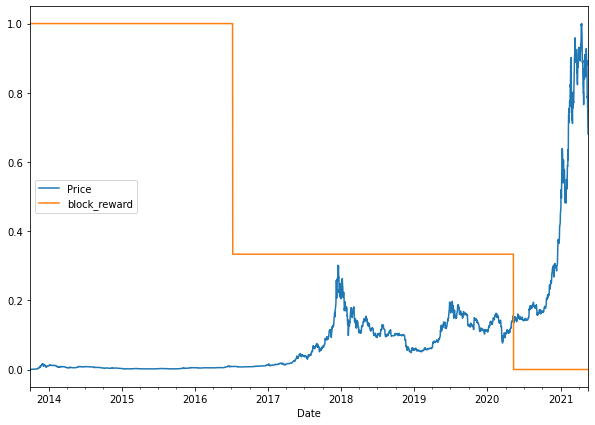

In [ ]:
# Let's plot our dataset!
from sklearn.preprocessing import minmax_scale # this allows us to plot both of our features on one normalized axis
scaled_price_block_df  = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

We can observe how the price generally increases as the block_reward decreases

## Making a windowed dataset with Pandas

The previous functions that we used to make a windowed dataset will not work since we are now using multivariate data. 

Since our data is organized as a Pandas DataFrame though we can use the built-in method `pandas.DataFrame.shift()` to create a windowed multivariate time series. 

The `shift()` method offsets an index by a specified number of periods.

In [ ]:
# Hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the BTC histortical dat with block reward feature
btc_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # This shifts values for each step in window_size
  btc_prices_windowed[f"Price+{i+1}"] = btc_prices_windowed["Price"].shift(periods=i+1)
btc_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


The next step is to separate our features (X) from our labels (y).

As a reminder: we are trying to use the previous `WINDOW_SIZE` to predict `HORIZON` steps. 

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [ ]:
# Create X and y, remove NANs and convert to float32 
X = btc_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = btc_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Create Train/Test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model_6 Dense - Multivariate time series

We will use the `model_1` architecture and use it to train and make prediction on the multivariate time series data, vs the univariate data used before. 

This will give us a clean comparison between univariate and multivariate.

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Note that the model inferred the input shape of our data.

In [ ]:
# Load best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 568.3355


568.3355102539062

In [ ]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8845.381 , 8769.115 , 9044.852 , 8745.515 , 8727.0625, 8773.182 ,
       8669.289 , 8502.578 , 8469.248 , 8527.997 ], dtype=float32)>

In [ ]:
# evaluate our predictions
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.33545,
 'mape': 2.5493133,
 'mase': 0.99840796,
 'mse': 1164860.0,
 'rmse': 1079.2867}

Looks like our model_6 barely improved from model_1 with the extra data.

In [ ]:
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

For different ideas on how to improve a neural network model (from a model perspective), refer to the [*Improving a model*](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.


Below we run again with the additional dense layer added.

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

# Load best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

# Predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))

# evaluate our predictions
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)

model_6_results


18/18 [==============================] - 0s 1ms/step - loss: 568.3416


{'mae': 568.34155,
 'mape': 2.5607429,
 'mase': 0.9984187,
 'mse': 1156008.4,
 'rmse': 1075.1783}

## Model_7: N-BEATS algorithm

In our previous models we have tried generally small architectures. Only a few layers.

However one of the best ways to improve a model is by adding more layers, which is what N-BEATS does. 

More information on [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) can be found here.

We are going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

We will not cover the whole paper, but will focus on 2 major areas. 
1. Replicate the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) 

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*

2. Use the same hyperparameters as the paper ([Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))

This allows us to:
* Create a custom layer for the `NBeatsBlock` by subclassing [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
  * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
* Implement a custom architecture using the Functional API 


### Building and testing an N-BEATS block layer

We will start with just one layer

In [ ]:
# Create N-BEATS custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for hte parent class (input_shape, trainable, name, etc.)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains a stack of 4 fully connected (Dense) layers each has a ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")
  
  def call(self, inputs): # the call method runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layers
      x = layer(x)
    theta = self.theta_layer(x)
    # Output backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

* The `call()` method is what is run when the layer is called:
  * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

  ![code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)
*Using TensorFlow layer subclassing to replicate the N-BEATS basic block. See section 3.1 of N-BEATS paper for details.*

Let's see our block replica in action by together by creating a toy version of `NBeatsBlock`.

Much of the creation of the time series materials (the ones you're going through now), including replicating the N-BEATS algorithm were streamed live on Twitch. If you'd like to see replays of how the algorithm was replicated, check out the [*Time series research and TensorFlow course material creation playlist*](https://youtube.com/playlist?list=PL8IpyNZ21vUSCM7nRAuS-hW_E-sgwdmaI) on the Daniel Bourke arXiv YouTube channel.

In [ ]:
# Create 'dummy' N-BEATS layer to represent input and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Here we will now pass these dummy inputs into the dummy NBEATS block layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# Print the activation ouputs of the theta layer (random because the model isn't trained)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.46348718  0.10944453 -0.43355346  0.9360242  -0.35703537 -0.17927602
 -0.34048367]
Forecast: -0.4397902190685272


### Preparing data for the N-BEATS algorithm using `tf.data`

Before jumping from the dummy blocks to creating the whole N-BEATS architecture we want to **create some data**!

Because of how large the NBEATS architecture is (we will see this later) we want to be able to run our data in the most efficient manner. Therefore we shall use the `tf.data` API.

Because N-BEATS is focused on **univariate** data we will start preparing the data by creating windowed datasets (like we've done before). 



In [ ]:
# Set hyperparameters
HORIZON = 1 # steps to predict forward using..
WINDOW_SIZE = 7 # this many previous steps




In [ ]:
# Create inputs
btc_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
btc_prices_nbeats = btc_prices.copy()

for i in range(WINDOW_SIZE):
  btc_prices_nbeats[f"Prices+{i+1}"] = btc_prices_nbeats["Price"].shift(periods=i+1)
btc_prices_nbeats.dropna().head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Extract features and labels
X = btc_prices_nbeats.dropna().drop("Price", axis=1)
y = btc_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

To help ensure that our test and train sets run as quickly as possible we will convert them to `tf.data.Dataset`. This is achieved by:

1. Use `tf.data.Dataset.from_tensor_slices()`
  * Note: this is good when all the dataset can fit in memory. For extremely large datasets `TFRecord` might be better
2. Combine labels and features tensors into dataset using `tf.data.Dataset.zip()`
3. Batch and prefetch the datasets using `batch()` and `prefetch()`.
  * Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible 

In [ ]:
# 1. Turn train and test sets arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine labels and features tensors
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. batch and prefetch
BATCH_SIZE = 1024 # as per Appendix D in NBEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Data prepared! Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get on with creating the N-BEATS architecture. 

### Setting up hyperparameters for NBEATS

We will use the hyperparameters outlined in Figure 1 and table 18/Appendix D in the NBEATS paper

[N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)
*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*


In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts. 

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).

In [ ]:
# Make Tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract 
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling, and fitting the N-BEATS algorithm

We are doing to run the above steps by performing the following steps:
1. Setup an instance of N-BEATS by using `NBeatsBlock` (this is the initial blocks and the rest will be created as part of stacks)
2. Create an input layer (we will use the Keras API)
3. Create initial backcast and forecast for the model with layer created in step 1
4. Use for looks to create stacks of block layers
5. Call the `NBeatsBlock` within the for loop from step 4 to create blocks that return backcasts and block-level forecasts
6. Create double residual stacking using `layers.subtract` and `layers.add` 
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model (loss=mae, optimizer=Adam)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [ ]:
#%% time

tf.random.set_seed(42)

# 1. Setup N-BEATS block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="InitialBlock")

# 2. Create Input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast inputs
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create block stacks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is created in 3.

  # 5. Use NBeatsBlock to calculate backcast and block forecast
  backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, backcast], name=f"add_{i}")
  
# 7. Put it all together. 
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae","mse"])

# 9. Fit the model!
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # minimize amount of output
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch takes a lot of time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 613: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 713: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


As with every other model let's
1. evaluate the best epoch
2. make predictions
3. evaluate results

In [1]:
# 1.
model_7.evaluate(test_dataset)

# 2. 
model_7_preds = make_preds(model_7, test_dataset)

# 3.
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)

# return
model_7_results

NameError: ignored

Wow quite amazing. So even with all of these layers This model doesn't perform as well as our model_1 or our naive forecast model. 

## Plot the N-BEATS architecture

Let's look at the structure that our model now has...

In [ ]:
# plot architecture
from tensorflow.keras.utils import plot_model

plot_model(model_7)

Our N-BEATS model replicates the N-BEATS **generic architecture**, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) for more. An extension could be to setup this kind of training regime and see if it improves performance.

Next, let's save this model.

In [ ]:
model_7.save(model_7.name)

## Model_8 Creating an ensemble

An ensemble as we were previouly introduced to is the combination, or stacking, of multiple models. 

By using an ensemble technique you can average or take the most certain answers from a set of models. 

For our ensemble models we are going to look at 
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models

We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal (Gaussian) distribution using He normal initialization, this'll help estimating the prediction intervals later on.

### constructing and fitting an ensemble model



In [2]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

NameError: ignored